In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
from torch.utils.data import Subset
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:1


In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Define data transformations (you can customize these as needed)
transform = transforms.Compose([
    transforms.Resize((224,224)),  # Resize the images to a common size
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image data
])
# Replace 'data_dir' with the path to your dataset folder
data_dir = '/raid/ee-mariyam/maryam/ayush/TiH_tomato_data'

# Load the dataset
dataset = ImageFolder(root=data_dir, transform=transform)
# Define the percentage split for train, validation, and test
train_percentage = 0.7
val_percentage = 0.3

# Calculate the sizes of each split
num_data = len(dataset)
num_train = int(train_percentage * num_data)
num_val = num_data - num_train

# Use random_split to split the dataset
train_dataset, val_dataset = random_split(dataset, [num_train, num_val], generator=torch.Generator().manual_seed(42))
# Define batch size for data loaders
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)


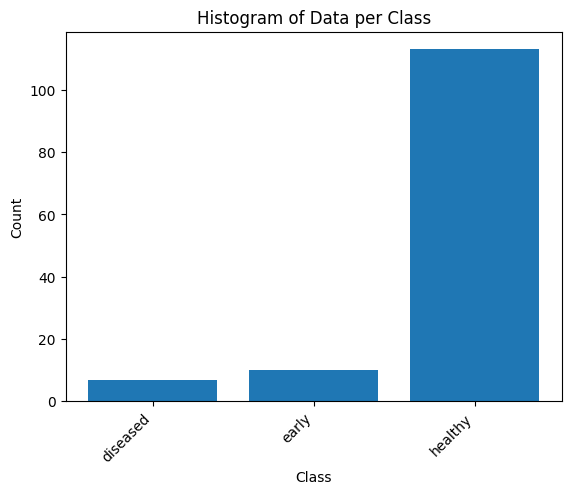

In [3]:
class_names = dataset.classes
num_classes = len(class_names)

# Initialize dictionary to count samples per class
class_counts = {class_name: 0 for class_name in class_names}

# Iterate through the train_loader to count samples per class
# for _, batch in enumerate(train_loader):
#     _, labels = batch
#     for label in labels:
#         class_name = class_names[label.item()]
#         class_counts[class_name] += 1

for _, batch in enumerate(val_loader):
    _, labels = batch
    for label in labels:
        class_name = class_names[label.item()]
        class_counts[class_name] += 1

# Plot the histogram
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Histogram of Data per Class')
plt.xticks(rotation=45, ha='right')
plt.show()

In [4]:
print(class_counts)

{'diseased': 7, 'early': 10, 'healthy': 113}


In [5]:
import timm
import torch
from timm.models import create_model

# Define model (choose appropriate ConvNeXt variant)
model = create_model('convnext_base', pretrained=True)  # Adjust variant (e.g., 'convnext_small', 'convnext_base')

# Freeze pre-trained layers for fine-tuning (optional)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify the final classifier layer for the number of PlantVillage classes
num_classes = 3  # Get number of classes from dataset
model.head.fc = nn.Linear(model.head.fc.in_features, num_classes)  # Replace final layer

# Unfreeze the last few layers for fine-tuning (optional)
for param in model.head.parameters():
    param.requires_grad = True  # Unfreeze final layers

/raid/ee-mariyam/maryam/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Fine-tune the model
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 20
training_start_time = time.time()
training_loss = []
validation_loss = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        # logits = outputs.logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    training_loss.append(train_loss)
    train_accuracy = 100 * correct_predictions / total_predictions

    # print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Train Accuracy: {train_accuracy:.2f}%")
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_correct_predictions = 0
    val_total_predictions = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_total_predictions += val_labels.size(0)
            val_correct_predictions += (val_predicted == val_labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    validation_loss.append(val_loss)
    val_accuracy = 100 * val_correct_predictions / val_total_predictions
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))

Epoch 1/20, Train Loss: 1.1061, Train Accuracy: 29.70%, Val Loss: 0.7043, Val Accuracy: 84.62%
Epoch 2/20, Train Loss: 0.6940, Train Accuracy: 80.86%, Val Loss: 0.4378, Val Accuracy: 86.92%
Epoch 3/20, Train Loss: 0.5881, Train Accuracy: 81.52%, Val Loss: 0.3742, Val Accuracy: 86.92%
Epoch 4/20, Train Loss: 0.5762, Train Accuracy: 81.52%, Val Loss: 0.3547, Val Accuracy: 86.92%


KeyboardInterrupt: 

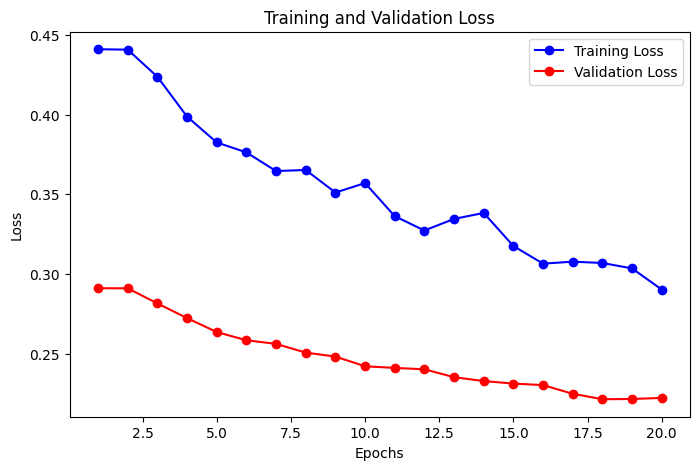

In [ ]:
import matplotlib.pyplot as plt

# Define the x-axis (epochs)
epochs = range(1, len(training_loss) + 1)

# Create a figure and plot the training loss and validation loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

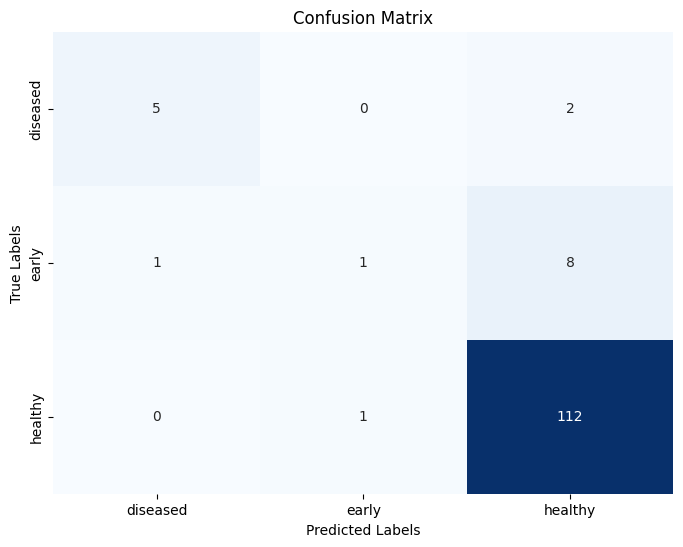

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:  # Replace 'dataloader' with your data loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Assuming a classification task with class indices
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
conf_matrix = confusion_matrix(all_labels, all_predictions)
# Plot the confusion matrix as a heatmap
class_names = ["diseased", "early", "healthy"] 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
